<a href="https://colab.research.google.com/github/skyprince999/AV-GOT-Ship-Identification/blob/master/AV_GoT_ShipIdentification_AzureCustomVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from IPython.display import clear_output

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/my_modules')
import unzipFiles

In [0]:
PATH = '/content/gdrive/My Drive/AV_GoT_Ships/'

categories = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

os.listdir()

['.config',
 'train.csv',
 '__MACOSX',
 'images',
 'test.csv',
 'valid',
 'sample_submission.csv',
 'train',
 'gdrive',
 'submission_format_500.csv',
 'sample_data']

In [0]:
unzipFiles.copyTest(PATH)
unzipFiles.unzipData(PATH)
unzipFiles.copyTrainValid(categories)

['.config', 'test.csv', 'sample_submission.csv', 'gdrive', 'sample_data']
Unzipped Successful
['.config', 'train.csv', '__MACOSX', 'images', 'test.csv', 'sample_submission.csv', 'gdrive', 'sample_data']
['.config', 'train.csv', '__MACOSX', 'images', 'test.csv', 'sample_submission.csv', 'gdrive', 'sample_data']
Shape of train file:  (6252, 2)
Number of categories:  5


0

In [0]:
# Read train & test files

trainDF = pd.read_csv('train.csv')
print(trainDF.shape)

testDF = pd.read_csv('test.csv')
print(testDF.shape)

(6252, 2)
(2680, 1)


In [0]:
!pip install azure-cognitiveservices-vision-customvision

In [0]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry

In [0]:
ENDPOINT = "https://southcentralus.api.cognitive.microsoft.com"

https://southcentralus.api.cognitive.microsoft.com/customvision/v3.0/Prediction/7e18b751-0b2d-4cde-8bd0-84653c70c905/classify/iterations/iteration4/image

# Replace with a valid key
training_key = "983a4aa1d0104e4ba8fe6c8de32d341d"
prediction_key = "587bf9e9007e43e3a9033c04f97cf78f" 
prediction_resource_id = "/subscriptions/15dc4e98-a0cf-4466-a045-0dcfcaaf85b1/resourceGroups/ship_identification/providers/Microsoft.CognitiveServices/accounts/ship_identification_prediction"

publish_iteration_name = "iteration4"

trainer = CustomVisionTrainingClient(training_key, endpoint=ENDPOINT)

# Create a new project
#print ("Creating project...")
print ("Get current project...")
#project = trainer.create_project("My Shipping Project")
project = trainer.get_project(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")

Get current project...


In [0]:
tagList =trainer.get_tags(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")


In [0]:
tagList = list()
# Make five tags in the new project
cargo_tag = trainer.create_tag(project.id, "Cargo")
military_tag = trainer.create_tag(project.id, "Military")
carrier_tag = trainer.create_tag(project.id, "Carrier")
cruise_tag = trainer.create_tag(project.id, "Cruise")
tankers_tag = trainer.create_tag(project.id, "Tankers")

In [0]:
tagList = [cargo_tag, military_tag, carrier_tag, cruise_tag, tankers_tag]

In [0]:
tagList[4].id

'2cb12e81-64b6-4437-9917-23a6bc335ad1'

In [0]:
project = trainer.get_project(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")

In [0]:
print("Adding images...")

image_list = []

for i in range(1,6):
  categoryDF = trainDF[ trainDF['category'] == i]
  sample = categoryDF.sample( n=600, random_state = 143567)
  print(i)
  print(sample.shape)
  for filename in sample['image']:
    filePath = 'train/' + str(i) +'/' + filename
    if(os.path.isfile(filePath)):
      with open(filePath, "rb") as image_contents:
        image_list.append(ImageFileCreateEntry(name=filename, contents=image_contents.read(), tag_ids=[tagList[i-1].id]))

    else:
      print('Error: Unable to find file: ', filename)
      


Adding images...
1
(600, 2)
Error: Unable to find file:  2794309.jpg
Error: Unable to find file:  2825168.jpg
Error: Unable to find file:  2868149.jpg
Error: Unable to find file:  2870146.jpg
Error: Unable to find file:  2782179.jpg
Error: Unable to find file:  2876110.jpg
Error: Unable to find file:  2827189.jpg
Error: Unable to find file:  2818951.jpg
Error: Unable to find file:  2829383.jpg
Error: Unable to find file:  2884433.jpg
Error: Unable to find file:  2784186.jpg
Error: Unable to find file:  2784292.jpg
Error: Unable to find file:  2804636.jpg
Error: Unable to find file:  2823066.jpg
Error: Unable to find file:  2868051.jpg
Error: Unable to find file:  2900621.jpg
Error: Unable to find file:  2860032.jpg
Error: Unable to find file:  2872101.jpg
Error: Unable to find file:  2864138.jpg
Error: Unable to find file:  2819088.jpg
Error: Unable to find file:  2888477.jpg
Error: Unable to find file:  2798403.jpg
Error: Unable to find file:  2860088.jpg
Error: Unable to find file:  

In [0]:
print(len(image_list))

2375


In [0]:
from msrest.exceptions import HttpOperationError

try:
  
  for i in range(0, len(image_list), 64):
    image_batch = image_list[i:i+64]
    upload_result = trainer.create_images_from_files(project.id, images=image_batch)

    if not upload_result.is_batch_successful:
      print("Image batch upload failed.")

      for image in upload_result.images:
        print("Image status: ", image.status)
      exit(-1)

except HttpOperationError as e:
  print(e.response.text)
  exit(-1)



Image batch upload failed.
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
I

In [0]:
#iter2 = trainer.get_iterations(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")

In [0]:
#for i in iter2:
#  print(i.id)

In [0]:
#project = trainer.get_project(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")

In [0]:
#project = trainer.update_iteration(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905", iteration_id = "479e992b-827d-4c64-9f9e-781428dc2624", name= 'iteration4')

In [0]:
#project.status

In [0]:
import time
publish_iteration_name = "iteration1000"

print ("Training...")
iteration = trainer.train_project(project.id, force_train=True, notification_email_address="aakashg80@gmail.com" )
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)



Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training


In [0]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_name = 'iteration1000' , prediction_id = prediction_resource_id)
print ("Done!")

Done!


In [0]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

# Now there is a trained endpoint that can be used to make a prediction
predictor = CustomVisionPredictionClient(prediction_key, endpoint=ENDPOINT)


In [0]:
testImage = testDF['image'][0]
testImage

'1007700.jpg'

In [0]:
project = trainer.get_project(project_id = "7e18b751-0b2d-4cde-8bd0-84653c70c905")

In [0]:


with open("images/" +testImage, "rb") as image_contents:
  results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
  
  # Display the results.
  for prediction in results.predictions:
    print ("\t" + prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))

	Cruise: 98.23%
	Military: 0.63%
	Tankers: 0.15%
	Cargo: 0.09%
	Carrier: 0.01%


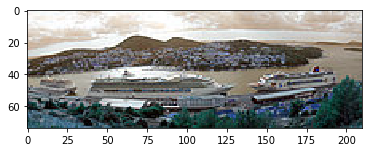

In [0]:
import cv2

img = cv2.imread(filename = 'images/'+ testImage)
plt.imshow(img)

In [0]:
allPredictions = list()

for idx, row in testDF.iterrows():
  pred = dict()
  
  print(idx)
  testImage = "images/" + row['image']
  
  if(os.path.isfile(testImage)):
    
    pred['image'] = row['image']
    with open(testImage, "rb") as image_contents:
      results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
    
    # Display the results.
    for prediction in results.predictions:
      print ("\t" + prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))
      pred[prediction.tag_name] = prediction.probability
      
  else:
    print("Unable to find file: ", row['image'])

  allPredictions.append(pred)
  
print(len(allPredictions))

0
	Cruise: 99.99%
	Military: 1.85%
	Tankers: 1.31%
	Carrier: 0.12%
	Cargo: 0.00%
1
	Cruise: 100.00%
	Tankers: 0.12%
	Cargo: 0.03%
	Carrier: 0.01%
	Military: 0.00%
2
	Cruise: 99.52%
	Tankers: 2.30%
	Cargo: 2.18%
	Military: 0.61%
	Carrier: 0.06%
3
	Military: 100.00%
	Cargo: 1.38%
	Tankers: 0.20%
	Cruise: 0.19%
	Carrier: 0.00%
4
	Cruise: 99.60%
	Carrier: 19.24%
	Military: 0.14%
	Cargo: 0.02%
	Tankers: 0.02%
5
	Cruise: 99.97%
	Carrier: 1.33%
	Tankers: 0.56%
	Cargo: 0.14%
	Military: 0.00%
6
	Cruise: 100.00%
	Tankers: 0.55%
	Carrier: 0.08%
	Cargo: 0.00%
	Military: 0.00%
7
	Military: 99.55%
	Tankers: 6.70%
	Cargo: 2.17%
	Cruise: 0.68%
	Carrier: 0.52%
8
	Military: 99.97%
	Cargo: 4.02%
	Cruise: 0.21%
	Tankers: 0.16%
	Carrier: 0.00%
9
	Cruise: 37.91%
	Cargo: 26.46%
	Tankers: 3.85%
	Carrier: 0.80%
	Military: 0.02%
10
	Cruise: 99.99%
	Tankers: 0.15%
	Cargo: 0.07%
	Military: 0.01%
	Carrier: 0.01%
11
	Cruise: 100.00%
	Tankers: 1.22%
	Military: 0.03%
	Cargo: 0.02%
	Carrier: 0.00%
12
	Cruise: 100.00%


In [0]:
allPredDF = pd.DataFrame(allPredictions)
print(allPredDF.shape)

(2680, 6)


In [0]:
allPredDF.head()

,Cargo,Carrier,Cruise,Military,Tankers,image
0,0.000037,0.001240,0.999858,0.018501,0.013105,1007700.jpg
1,0.000257,0.000126,0.999999,0.000001,0.001224,1011369.jpg
2,0.021789,0.000567,0.995189,0.006072,0.022999,1051155.jpg
3,0.013783,0.000003,0.001860,0.999980,0.001955,1062001.jpg
4,0.000249,0.192440,0.995978,0.001439,0.000166,1069397.jpg


In [0]:
allPredDF.to_csv('/content/gdrive/My Drive/AV_GoT_Ships/submission_30May2019_0700.csv')

allPredDF['categoryName'] = allPredDF[['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']].apply(np.argmax, axis=1)
#allPredDF['categoryName'] = allPredDF[].apply(np.argmax, axis=1)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [0]:
#allPredDF['image'] = testDF['image']
allPredDF.head()

,Cargo,Carrier,Cruise,Military,Tankers,image,categoryName
0,0.000037,0.001240,0.999858,0.018501,0.013105,1007700.jpg,Cruise
1,0.000257,0.000126,0.999999,0.000001,0.001224,1011369.jpg,Cruise
2,0.021789,0.000567,0.995189,0.006072,0.022999,1051155.jpg,Cruise
3,0.013783,0.000003,0.001860,0.999980,0.001955,1062001.jpg,Military
4,0.000249,0.192440,0.995978,0.001439,0.000166,1069397.jpg,Cruise


Cruise
Cruise
Cruise
Military
Cruise
Cruise
Cruise
Military


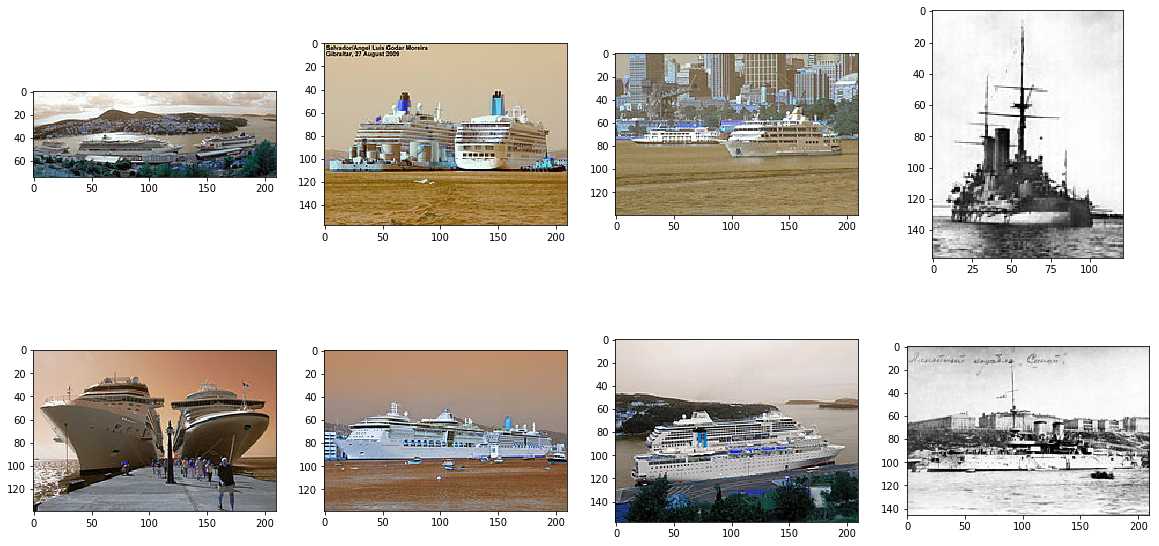

In [0]:
fig = plt.figure(figsize=(20,10))

for idx, row in allPredDF.iterrows():
  print(row['categoryName'])
  img = cv2.imread(filename = 'images/'+ row['image'])
  fig.add_subplot(2,4, idx+1)
  plt.imshow(img)
  if idx + 1 == 8:
    break

In [0]:
allPredDF['category'] = allPredDF['categoryName'].apply(lambda x: categories[x])
allPredDF.head()

,Cargo,Carrier,Cruise,Military,Tankers,image,categoryName,category
0,0.000037,0.001240,0.999858,0.018501,0.013105,1007700.jpg,Cruise,4
1,0.000257,0.000126,0.999999,0.000001,0.001224,1011369.jpg,Cruise,4
2,0.021789,0.000567,0.995189,0.006072,0.022999,1051155.jpg,Cruise,4
3,0.013783,0.000003,0.001860,0.999980,0.001955,1062001.jpg,Military,2
4,0.000249,0.192440,0.995978,0.001439,0.000166,1069397.jpg,Cruise,4


In [0]:
allPredDF[['image', 'category']].to_csv('submission_format_500.csv', index=False)

In [0]:
from google.colab import files

files.download('submission_format_500.csv')